# **Case QuantumFinance - Disciplina NLP - Classificador de chamados**

**Atenção:**
- Leia com atenção o descritivo do trabalho e as orientações do template.
- O trabalho deve ser entregue respeitando a estrutura do arquivo de template em notebook "Template_Trabalho_Final_NLP.ipynb" e compactado no formato .zip. Apenas um arquivo no formato .ipynb deve ser entregue consolidando todo o trabalho.

***Participantes (RM - NOME):***<br><br>
359735 - Jéssica Portela de Castro<br>
358404 - Tiago Freire Barbosa<br><br>

###**Crie um classificador de chamados aplicando técnicas de PLN**
---

A **QuantumFinance** tem um canal de atendimento via chat e precisar classificar os assuntos dos atendimentos para melhorar as tratativas dos chamados dos clientes. O canal recebe textos abertos dos clientes relatando o problema e/ou dúvida e depois é direcionado para alguma área especialista no assunto para uma melhor tratativa.​

1. Crie ao menos um modelo classificador de assuntos aplicando técnicas de NLP (PLN), Vetorização (n-grama + métrica) e modelo supervisionado, que consiga classificar através de um texto o assunto conforme disponível na base de dados [1] para treinamento e validação do seu modelo.​

  O modelo precisar atingir um score na **métrica F1 Score superior a 75%**. Utilize o dataset [1] para treinar e testar o modelo, separe o dataset em duas amostras (75% para treinamento e 25% para teste com o randon_state igual a 42).​

2. Utilizar ao menos uma aplicação de modelos com Embeddings usando Word2Vec e/ou LLM´s para criar o modelo classificador com os critérios do item 1. Não é necessário implementar aplicações usando serviços de API da OpenAI ou outros por exemplo.

Fique à vontade para testar e explorar as técnicas de pré-processamento, abordagens de NLP, algoritmos e bibliotecas, mas explique e justifique as suas decisões durante o desenvolvimento.​

**Composição da nota:​**

**50%** - Demonstrações das aplicações das técnicas de PLN (regras, pré-processamentos, tratamentos, variedade de modelos aplicados, aplicações de GenIA, organização do pipeline, etc.)​

**50%** - Baseado na performance (score) obtida com a amostra de teste no pipeline do modelo campeão (validar com  a Métrica F1 Score). **Separar o pipeline completo do modelo campeão conforme template.​**

O trabalho poderá ser feito em grupo de 2 até 4 pessoas (mesmo grupo do Startup One) e trabalhos iguais serão descontado nota e passível de reprovação.

**[1] = ​https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv**

**[F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)** com average='weighted'

#### Importação das Bibliotecas

Necessário executar, reiniciar o ambiente e executar novamente para correto funcionamento do gensim<br>

Centralizamos nesta célula todas as importações, para melhorar a organização do código<br>

Posteriormente no modelo campeão serão importadas apenas as bibliotecas necessária, para execução de forma independente

In [1]:
!pip install gensim==4.3.2 scipy==1.10.1 numpy==1.26.4 --quiet
!python -m spacy download pt_core_news_sm --quiet

import pandas as pd
import nltk
import string
import warnings
import spacy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 75.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#### Importação de Dataset

In [2]:
df = pd.read_csv('https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv', delimiter=';')

#### Análise Exploratória de Dados

- O dataset possui **21072** linhas e **4** colunas

- Não possui valores nulos

- Os tipos de dados estão distrubuídos entre **int64** e **Object**

In [3]:
df.info()
print('\n')
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id_reclamacao         21072 non-null  int64 
 1   data_abertura         21072 non-null  object
 2   categoria             21072 non-null  object
 3   descricao_reclamacao  21072 non-null  object
dtypes: int64(1), object(3)
memory usage: 658.6+ KB




(21072, 4)

Visualização das linhas iniciais

In [4]:
df.head(10)

,id_reclamacao,data_abertura,categoria,descricao_reclamacao
0,3229299,2019-05-01T12:00:00-05:00,Hipotecas / Empréstimos,"Bom dia, meu nome é xxxx xxxx e agradeço se vo..."
1,3199379,2019-04-02T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...
2,3233499,2019-05-06T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,O cartão Chase foi relatado em xx/xx/2019. No ...
3,3180294,2019-03-14T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,"Em xx/xx/2018, enquanto tentava reservar um ti..."
4,3224980,2019-04-27T12:00:00-05:00,Serviços de conta bancária,"Meu neto me dê cheque por {$ 1600,00} Eu depos..."
5,3209411,2019-04-11T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,Você pode remover a consulta
6,3331023,2019-08-06T12:00:00-05:00,Serviços de conta bancária,Sem aviso prévio J.P. Morgan Chase restringiu ...
7,3352857,2019-08-24T12:00:00-05:00,Outros,"Durante os meses de verão, experimento uma ren..."
8,3226110,2019-04-29T12:00:00-05:00,Roubo / Relatório de disputa,"Em xxxx xx/xx/2019, fiz um pagamento {$ 300.00..."
9,3237765,2019-05-09T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,Eu tenho um cartão de crédito Chase que está r...


Visualizando texto do campo de descrição da reclamação, aqui notamos que o texto possui pontuação, caracteres em diferentes tamanhos, mascaramento de dados, e stopwords evidenciando a necessidade de normalização e pré-processamento destes textos

In [5]:
df['descricao_reclamacao'][6]

'Sem aviso prévio J.P. Morgan Chase restringiu minha conta pelo meu cartão de débito terça -feira xx/xx/2019. Na quinta -feira, xx/xx/2019, entrei em uma filial depois de ser aconselhado por um representante de atendimento ao cliente de que minha conta seria realmente fechada. Entrei na filial para ver como posso remover os fundos que estão lá atualmente, como se meu depósito direto do meu local de trabalho fosse devolvido. O Associado do Banco e o Representante de Atendimento ao Cliente me garantiram que os fundos publicariam, mas eles podem levar um dia útil adicional. Naquele sábado, tentei entrar em uma filial mais uma vez para recuperar meus fundos que realmente publicaram na sexta -feira, xx/xx/2019. Ao olhar para minha conta, percebo que os fundos foram revertidos e não estavam mais presentes na minha declaração atual. Fui chamado e me disseram que pode levar dois dias úteis informando na terça -feira, xx/xx/xxxx seria a data em que meus fundos estariam disponíveis para retirar 

In [6]:
df['descricao_reclamacao'][8]

'Em xxxx xx/xx/2019, fiz um pagamento {$ 300.00} a um varejista on -line usando o Chase Quick Pay com xxxx no site da Chase. Percebi que este era um site de fraudes após nenhuma confirmação, produto ou resposta a quaisquer perguntas sobre o pedido e contatou o Chase para obter mais informações sobre a transação para tentar obter um reembolso pelo banco de varejistas.\r\n\r\nEntrei em contato com o Chase por meio de uma mensagem segura em xx/xx/2019 explicando o que aconteceu e perguntei: "Existe uma maneira de reverter essa transação, ou você tem um contato no XXXX que pode me fornecer mais informações sobre o destinatário? \'\' Que xxxx , minha mensagem foi revisada e recebi uma resposta reafirmando meu e -mail original e me informando que "a transferência foi concluída. No entanto, como você mencionou que o site é uma farsa enquanto podemos lidar com a maioria das perguntas por e -mail, algumas exigem a experiência de outra equipe. Para ajudá -lo melhor em relação ao reembolso, solic

No dataset que existe uma distribuição de categorias similar entre **Serviços de conta bancária**, **Cartão de crédito / Cartão pré-pago** e **Roubo / Relatório de disputa**, enquanto **Hipotecas / Empréstimos** e **Outros** encontram-se um pouco distante das demais categorias em questão de quantidade de amostras

<Axes: ylabel='categoria'>

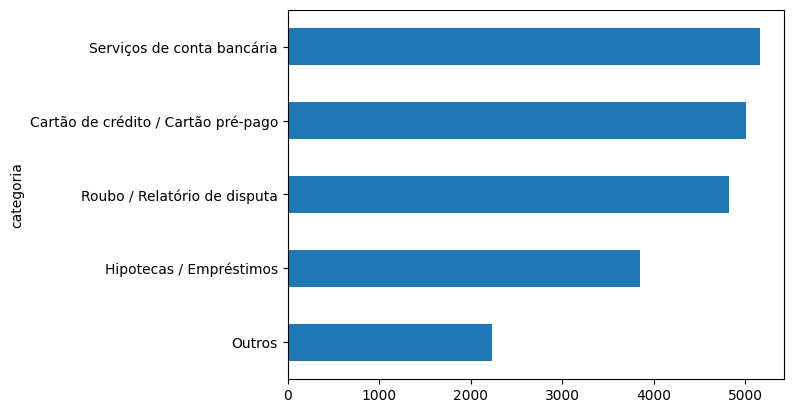

In [7]:
df['categoria'].value_counts(ascending=True).plot(kind='barh')

Bom desenvolvimento!

###**Area de desenvolvimento e validações**

Faça aqui as demonstrações das aplicações das técnicas de PLN (regras, pré-processamentos, tratamentos, variedade de modelos aplicados, organização do pipeline, etc.)​

Fique à vontade para testar e explorar as técnicas de pré-processamento, abordagens de NLP, algoritmos e bibliotecas, mas explique e justifique as suas decisões durante o desenvolvimento.​

#### DecisionTreeClassifier

Nos pipelines abaixo, testaremos inicialmente com o modelo **DecisionTreeClassifier**, posteriomente implementaremos demais modelos de classificação com o pipeline de melhor resultado para comparação

##### Pipeline 01 - Vetorização BOW + Unigrama + Remoção de Stopwords

- Este pipeline realiza a classificação de textos com base em vetorização Bag of Words (BoW), utilizando unigramas e remoção de stopwords

- os dados são copiados e divididos em conjuntos de treino e teste, com 75% dos dados para treino e 25% para teste

- Em seguida, são baixadas as listas de stopwords do NLTK em português, sendo que duas palavras adicionais ("xx" e "xxxx") são incluídas manualmente para remoção posterior

- Para o pré-processamento, são definidas duas funções: uma para remoção de pontuação e outra que realiza a normalização completa do texto. Essa normalização inclui conversão para minúsculas, remoção de pontuação e dígitos, tokenização com word_tokenize, remoção de stopwords e de palavras com menos de três caracteres. O texto limpo é então reconstruído como uma string normalizada

- Após a limpeza, o vetor de texto é criado com a ferramenta CountVectorizer, configurada para gerar unigramas (ou seja, palavras isoladas) e eliminar as stopwords customizadas. O CountVectorizer é ajustado somente com os dados de treino, garantindo que o vocabulário do modelo não incorpore informações do conjunto de teste

- Com o vocabulário aprendido, os textos de treino e teste são transformados em vetores numéricos esparsos, representando a frequência das palavras em cada documento. Esses vetores são usados para treinar um modelo do tipo DecisionTreeClassifier, que tenta aprender padrões entre os vetores de texto e suas respectivas categorias

- Ao final, o modelo realiza previsões no conjunto de teste, e a performance é avaliada utilizando a métrica F1 Score com média ponderada (average='weighted'), adequada para situações em que as classes estão desbalanceadas

In [8]:
df_pipeline_01 = df.copy()

df_train, df_test = train_test_split(
    df_pipeline_01,
    test_size=0.25,
    random_state=42
)

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

stopwords = nltk.corpus.stopwords.words('portuguese')

stopwords_new = stopwords + ["xx", "xxxx"]

def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text

def normalize_str(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stopwords_new]
    text = [y for y in text if len(y) > 2]
    return " ".join([t for t in text])

df_train['descricao_reclamacao'] = df_train['descricao_reclamacao'].apply(normalize_str)

df_test['descricao_reclamacao'] = df_test['descricao_reclamacao'].apply(normalize_str)

vect = CountVectorizer(ngram_range=(1,1), stop_words=stopwords_new)
vect.fit(df_train.descricao_reclamacao)

x_train = vect.transform(df_train.descricao_reclamacao)
y_train = df_train["categoria"]

model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

x_test = vect.transform(df_test.descricao_reclamacao)

y_prediction = model.predict(x_test)

y_test = df_test["categoria"]
f1 = f1_score(y_test, y_prediction,average='weighted')
print("F1 Score:", f1)

F1 Score: 0.7309240224346284


##### Pipeline 02 - Vetorização BOW + Unigrama & Bigrama + Remoção de Stopwords

Pipeline semelhante ao anterior com a diferença que neste, implementamos unigramas e bigramas no **CountVectorizer**

In [9]:
df_pipeline_02 = df.copy()

df_train, df_test = train_test_split(
    df_pipeline_02,
    test_size=0.25,
    random_state=42
)

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

stopwords = nltk.corpus.stopwords.words('portuguese')

stopwords_new = stopwords + ["xx", "xxxx"]

def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text

def normalize_str(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stopwords_new]
    text = [y for y in text if len(y) > 2]
    return " ".join([t for t in text])

df_train['descricao_reclamacao'] = df_train['descricao_reclamacao'].apply(normalize_str)

df_test['descricao_reclamacao'] = df_test['descricao_reclamacao'].apply(normalize_str)

vect = CountVectorizer(ngram_range=(1,2), stop_words=stopwords_new)
vect.fit(df_train.descricao_reclamacao)

x_train = vect.transform(df_train.descricao_reclamacao)
y_train = df_train["categoria"]

model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

x_test = vect.transform(df_test.descricao_reclamacao)

y_prediction = model.predict(x_test)

y_test = df_test["categoria"]
f1 = f1_score(y_test, y_prediction,average='weighted')
print("F1 Score:", f1)

F1 Score: 0.7454976711454935


##### Pipeline 03 - Vetorização TF-IDF + Lematização + Unigrama + Remoção de Stopwords

- Pipeline semelhante aos anteriores com a diferença de que neste implementamos a função **lemmatizer_text** para efetuar a lematização com a biblioteca Spacy<br>

- Aqui utilizamos TF-IDF para vetorização, com unigrama e remoção de stopwords

In [10]:
df_pipeline_03 = df.copy()

df_train, df_test = train_test_split(
    df_pipeline_03,
    test_size=0.25,
    random_state=42
)

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nlp = spacy.load('pt_core_news_sm')

stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords_new = stopwords + ["xx", "xxxx"]

def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text

def normalize_str(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stopwords_new]
    text = [y for y in text if len(y) > 2]
    return " ".join([t for t in text])

def lemmatizer_text(text):
  sent = []
  doc = nlp(text)
  for word in doc:
      sent.append(word.lemma_)
  return " ".join(sent)

df_train['descricao_reclamacao'] = df_train['descricao_reclamacao'].apply(normalize_str)

df_test['descricao_reclamacao'] = df_test['descricao_reclamacao'].apply(normalize_str)

df_train['descricao_reclamacao'] = df_train['descricao_reclamacao'].apply(lemmatizer_text)

df_test['descricao_reclamacao'] = df_test['descricao_reclamacao'].apply(lemmatizer_text)

vect = TfidfVectorizer(ngram_range=(1,1), use_idf=True, stop_words=stopwords_new)
vect.fit(df_train.descricao_reclamacao)

x_train = vect.transform(df_train.descricao_reclamacao)
y_train = df_train["categoria"]

model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

x_test = vect.transform(df_test.descricao_reclamacao)

y_prediction = model.predict(x_test)

y_test = df_test["categoria"]
f1 = f1_score(y_test, y_prediction,average='weighted')
print("F1 Score:", f1)

F1 Score: 0.757195929538738


##### Pipeline 04 - Vetorização TF-IDF + Lematização + Unigrama & Bigrama + Remoção de Stopwords

Neste pipeline implementamos lógica semelhante aos demais, porém neste efetuamos a remoção de stopwords do NLTK e Spacy<br>

Aqui implementamos vetorização com **TF-IDF**, utilizando unigramas e bigramas<br>

De todos os modelos até o momento este atingiu o maior **F1-Score**

In [11]:
df_pipeline_04 = df.copy()

df_train, df_test = train_test_split(
    df_pipeline_04,
    test_size=0.25,
    random_state=42
)

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nlp = spacy.load('pt_core_news_sm')

stopwords = list(set(nlp.Defaults.stop_words).union(set(nltk.corpus.stopwords.words('portuguese'))))
stopwords_new = stopwords + ["xx", "xxxx"]

def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text

def normalize_str(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stopwords_new]
    text = [y for y in text if len(y) > 2]
    return " ".join([t for t in text])

def lemmatizer_text(text):
  sent = []
  doc = nlp(text)
  for word in doc:
      sent.append(word.lemma_)
  return " ".join(sent)

df_train['descricao_reclamacao'] = df_train['descricao_reclamacao'].apply(normalize_str)

df_test['descricao_reclamacao'] = df_test['descricao_reclamacao'].apply(normalize_str)

df_train['descricao_reclamacao'] = df_train['descricao_reclamacao'].apply(lemmatizer_text)

df_test['descricao_reclamacao'] = df_test['descricao_reclamacao'].apply(lemmatizer_text)

vect = TfidfVectorizer(ngram_range=(1,2), use_idf=True, stop_words=stopwords_new)
vect.fit(df_train.descricao_reclamacao)

x_train = vect.transform(df_train.descricao_reclamacao)
y_train = df_train["categoria"]

model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

x_test = vect.transform(df_test.descricao_reclamacao)

y_prediction = model.predict(x_test)

y_test = df_test["categoria"]
f1_tree = f1_score(y_test, y_prediction,average='weighted')
print("F1 Score:", f1_tree)

F1 Score: 0.7627874466001402


###### LogisticRegression

In [12]:
model = LogisticRegression(random_state=42)
model.fit(x_train, y_train)

x_test = vect.transform(df_test.descricao_reclamacao)

y_prediction = model.predict(x_test)

y_test = df_test["categoria"]
f1_lr = f1_score(y_test, y_prediction,average='weighted')
print("F1 Score:", f1_lr)

F1 Score: 0.9073597218887184


###### NaiveBayes

In [13]:
model = MultinomialNB()
model.fit(x_train, y_train)

x_test = vect.transform(df_test.descricao_reclamacao)

y_prediction = model.predict(x_test)

y_test = df_test["categoria"]
f1_nb = f1_score(y_test, y_prediction,average='weighted')
print("F1 Score:", f1_nb)

F1 Score: 0.7319836368831959


###### RandomForest

In [14]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

x_test = vect.transform(df_test.descricao_reclamacao)

y_prediction = model.predict(x_test)

y_test = df_test["categoria"]
f1_rf = f1_score(y_test, y_prediction,average='weighted')
print("F1 Score:", f1_rf)

F1 Score: 0.8063001769268272


#### Resultados

A partir do **pipeline 04**, modelo que atingiu maior F1-Score com o modelo **DecisionClassifier**, treinamos 3 outros modelos de classificação, sendo que entre todos **LogisticRegression** atingiu o maior F1-Score

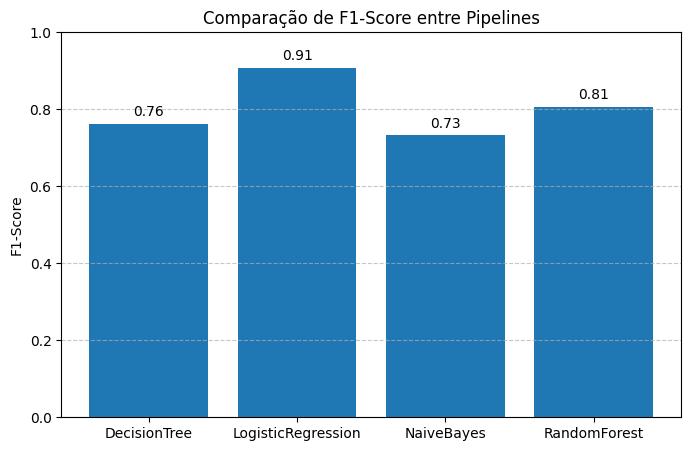

In [15]:
nomes = ['DecisionTree', 'LogisticRegression', 'NaiveBayes', 'RandomForest']

f1_scores = [f1_tree, f1_lr, f1_nb, f1_rf]

plt.figure(figsize=(8,5))
plt.bar(nomes, f1_scores)
plt.title('Comparação de F1-Score entre Pipelines')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)


for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')

plt.show()

#### DecisionTreeClassifier + Embeddings Word2Vec

Download e descompactação do arquivo de embeddings

In [16]:
!wget 'https://dados-ml-pln.s3-sa-east-1.amazonaws.com/skip_s300.zip'

!unzip 'skip_s300.zip'

--2025-07-14 23:34:35--  https://dados-ml-pln.s3-sa-east-1.amazonaws.com/skip_s300.zip
Resolving dados-ml-pln.s3-sa-east-1.amazonaws.com (dados-ml-pln.s3-sa-east-1.amazonaws.com)... 3.5.232.253, 52.95.165.27, 3.5.234.43, ...
Connecting to dados-ml-pln.s3-sa-east-1.amazonaws.com (dados-ml-pln.s3-sa-east-1.amazonaws.com)|3.5.232.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958619745 (914M) [application/zip]
Saving to: ‘skip_s300.zip’

skip_s300.zip       100%[===================>] 914.21M  20.6MB/s    in 49s     

2025-07-14 23:35:25 (18.7 MB/s) - ‘skip_s300.zip’ saved [958619745/958619745]

Archive:  skip_s300.zip
  inflating: skip_s300.txt           


In [17]:
model_skip = KeyedVectors.load_word2vec_format('skip_s300.txt')

##### Pipeline 05 - Vetorização TF-IDF + Lematização + Unigrama & Bigrama + Remoção de Stopwords

- Este pipeline utiliza vetores de palavras com Word2Vec (modelo model_skip) e uma árvore de decisão como classificador

- Primeiramente, ele realiza uma cópia do DataFrame original e divide os dados em conjuntos de treino e teste, com 25% dos dados reservados para teste e 75% para treino

- Em seguida, são baixados recursos do NLTK e carregado o modelo da língua portuguesa do spaCy. As stopwords padrão do spaCy e do NLTK são combinadas em uma única lista, acrescida de termos adicionais ("xx", "xxxx")

- O texto é então normalizado por meio de funções que convertem tudo para minúsculas, removem pontuações, dígitos, stopwords e palavras curtas.

- Após a normalização, cada descrição de reclamação é transformada em um vetor numérico através da função **average_vector**, calculando-se a média dos vetores Word2Vec das palavras presentes no texto

- Com os dados vetorizados, o modelo DecisionTreeClassifier é treinado com os vetores do conjunto de treino e suas respectivas categorias

- Posteriormente, o modelo é testado com os dados de teste, e o desempenho é avaliado utilizando a métrica F1-Score ponderada

- Escolhemos o modelo skip_s300 para classificação porque ele gera vetores de palavras mais ricos semanticamente, capturando melhor o contexto mesmo em textos curtos ou com palavras menos frequentes, o que melhora o desempenho do classificador em tarefas de categorização textual

In [18]:
df_pipeline_05 = df.copy()

df_train, df_test = train_test_split(
    df_pipeline_05,
    test_size=0.25,
    random_state=42
)

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nlp = spacy.load('pt_core_news_sm')

stopwords = list(set(nlp.Defaults.stop_words).union(set(nltk.corpus.stopwords.words('portuguese'))))
stopwords_new = stopwords + ["xx", "xxxx"]

def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text

def normalize_str(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stopwords_new]
    text = [y for y in text if len(y) > 2]
    return " ".join([t for t in text])

vectorizer = model_skip

def average_vector(words):
  vectors = [vectorizer[word] for word in words if word in vectorizer]
  if vectors:
    return sum(vectors) / len(vectors)
  else:
    vector_size = vectorizer.vector_size
    wv_res = np.zeros(vector_size)
    return wv_res

df_train['descricao_reclamacao'] = df_train['descricao_reclamacao'].apply(normalize_str)

df_test['descricao_reclamacao'] = df_test['descricao_reclamacao'].apply(normalize_str)

df_train['descricao_reclamacao'] = df_train['descricao_reclamacao'].apply(average_vector)

df_test['descricao_reclamacao'] = df_test['descricao_reclamacao'].apply(average_vector)

x_train = df_train['descricao_reclamacao']
y_train = df_train["categoria"]

model = DecisionTreeClassifier(random_state=42)
model.fit(list(x_train), y_train)

x_test = df_test['descricao_reclamacao']
y_test = df_test["categoria"]

y_prediction = model.predict(list(x_test))

f1_tree_w2v = f1_score(y_test, y_prediction,average='weighted')
print("F1 Score:", f1_tree_w2v)

F1 Score: 0.4368768851511542


###### LogisticRegression

In [19]:
model = LogisticRegression(random_state=42)
model.fit(list(x_train), y_train)

x_test = df_test['descricao_reclamacao']
y_test = df_test["categoria"]

y_prediction = model.predict(list(x_test))

f1_lr_w2v = f1_score(y_test, y_prediction,average='weighted')
print("F1 Score:", f1_lr_w2v)

F1 Score: 0.5757857611108066


###### RandomForest

In [20]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(list(x_train), y_train)

x_test = df_test['descricao_reclamacao']
y_test = df_test["categoria"]

y_prediction = model.predict(list(x_test))

f1_rf_w2v = f1_score(y_test, y_prediction,average='weighted')
print("F1 Score:", f1_rf_w2v)

F1 Score: 0.5871349438125817


#### Resultados

Os modelos com Word2Vec apresentaram desempenho inferior em comparação com modelos anteriores

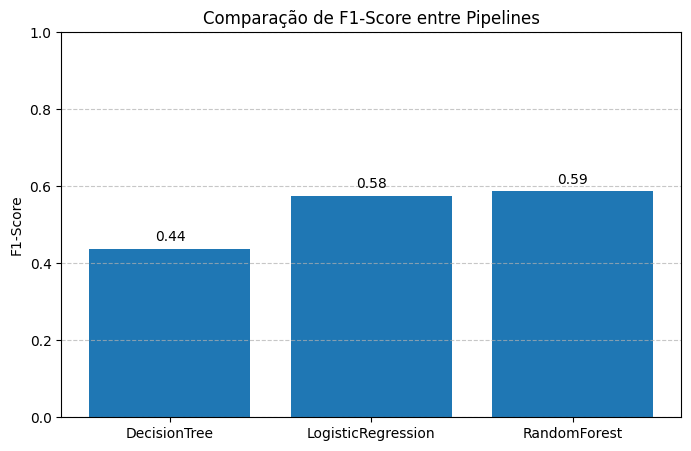

In [22]:
nomes = ['DecisionTree', 'LogisticRegression', 'RandomForest']

f1_scores = [f1_tree_w2v, f1_lr_w2v, f1_rf_w2v]

plt.figure(figsize=(8,5))
plt.bar(nomes, f1_scores)
plt.title('Comparação de F1-Score entre Pipelines')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)


for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')

plt.show()

###**Validação do professor**

Consolidar apenas os scripts do seu **modelo campeão**, desde o carregamento do dataframe, separação das amostras, tratamentos utilizados (funções, limpezas, etc.), criação dos objetos de vetorização dos textos e modelo treinado e outras implementações utilizadas no processo de desenvolvimento do modelo.

O modelo precisar atingir um score na métrica F1 Score superior a 75%.

**Atenção:**
- **Implemente aqui apenas os scripts que fazem parte do modelo campeão.**
- **Execute o pipeline do modelo campeão completamente para garantir que não tetá erros no script.**


#### Modelo Campeão 🏆 - Vetorização TF-IDF + Lematização + Unigrama & Bigrama + Remoção de Stopwords + LogisticRegression

- Nosso pipeline campeão implementa classificação de texto, utilizando pré-processamento linguístico com spaCy e NLTK, vetorização com TF-IDF bigramas e classificação com Regressão Logística

- Inicialmente, o modelo de linguagem pt_core_news_sm do spaCy é baixado para permitir a lematização de textos em português. Em seguida, são importadas bibliotecas relevantes e suprimidos avisos para manter o notebook mais limpo

- O conjunto de dados é copiado e dividido em treino e teste (75%/25%). Recursos como stopwords são carregados tanto do spaCy quanto do NLTK e combinados em uma lista estendida com termos extras ("xx", "xxxx").

- Funções de limpeza textual são aplicadas para: remover pontuação e números, tokenizar palavras, eliminar stopwords e palavras curtas, lematizar os tokens com o modelo do spaCy, transformando palavras para suas formas base

- Após o pré-processamento, os textos são vetorizados com TfidfVectorizer configurado para unigramas e bigramas, e com remoção de stopwords personalizada

- O modelo Logistic Regression é treinado com os dados vetorizados de treino

- Por fim, o modelo é testado com os dados de teste transformados, e a performance é avaliada por meio do F1-Score ponderado, que é impresso como métrica final da classificação

In [23]:
!python -m spacy download pt_core_news_sm --quiet

import pandas as pd
import nltk
import string
import warnings
import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from nltk.tokenize import word_tokenize

warnings.filterwarnings('ignore')

df = pd.read_csv('https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv', delimiter=';')

df_pipeline_campeao = df.copy()

df_train, df_test = train_test_split(
    df_pipeline_campeao,
    test_size=0.25,
    random_state=42
)

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nlp = spacy.load('pt_core_news_sm')

stopwords = list(set(nlp.Defaults.stop_words).union(set(nltk.corpus.stopwords.words('portuguese'))))
stopwords_new = stopwords + ["xx", "xxxx"]

def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text

def normalize_str(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stopwords_new]
    text = [y for y in text if len(y) > 2]
    return " ".join([t for t in text])

def lemmatizer_text(text):
  sent = []
  doc = nlp(text)
  for word in doc:
      sent.append(word.lemma_)
  return " ".join(sent)

df_train['descricao_reclamacao'] = df_train['descricao_reclamacao'].apply(normalize_str)

df_test['descricao_reclamacao'] = df_test['descricao_reclamacao'].apply(normalize_str)

df_train['descricao_reclamacao'] = df_train['descricao_reclamacao'].apply(lemmatizer_text)

df_test['descricao_reclamacao'] = df_test['descricao_reclamacao'].apply(lemmatizer_text)

vect = TfidfVectorizer(ngram_range=(1,2), use_idf=True, stop_words=stopwords_new)
vect.fit(df_train.descricao_reclamacao)

x_train = vect.transform(df_train.descricao_reclamacao)
y_train = df_train["categoria"]

model = LogisticRegression(random_state=42)
model.fit(x_train, y_train)

x_test = vect.transform(df_test.descricao_reclamacao)

y_prediction = model.predict(x_test)

y_test = df_test["categoria"]
f1_lr_campeao = f1_score(y_test, y_prediction,average='weighted')
print("\n\nF1 Score:", f1_lr_campeao)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 41.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


F1 Score: 0.9073597218887184
